In [1]:
# uses conda environment gpflow5_0
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature 
from matplotlib.lines import Line2D
from matplotlib.colors import Normalize
from matplotlib import cm
from matplotlib import colors
import matplotlib.patches as patches
from matplotlib.patches import Rectangle 
plt.rc('figure', max_open_warning = 0)
import random
from random import gauss

import pandas as pd
import tensorflow as tf
import xarray as xr
import cartopy.crs as ccrs
import scipy.io as io
import gpflow as gpf
from gpflow.utilities import print_summary, set_trainable
import tensorflow_probability as tfp
from tensorflow_probability import bijectors as tfb

from itertools import product
import glob

    
# set the colormap and centre the colorbar
class MidpointNormalize(Normalize):
    """Normalise the colorbar.  e.g. norm=MidpointNormalize(mymin, mymax, 0.)"""
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y), np.isnan(value))

In [2]:
#Initialize parameters
ice_model = 'd6g_h6g_'
lith_thickness = 'l9'# 'l90C'
# viscosity = '_umVM5_lmVM5'
# run = ice_model + lith_thickness + viscosity
place = 'Europe'

locs = {'england':[2, -12, 60, 50], 
            'southchina':[117, 110, 23, 19], 
            'easternhem':[165, 70, 45, -45], 
            'westernhem':[30, -175, 75, -80],
           'world':[179.8, -179.8, 90, -90],
           'namerica': [-20, -150, 75, 10], 
           'eastcoast': [-65, -88, 40, 15],
           'Europe': [-20, 15, 35, 70]}
extent = locs[place]
tmax, tmin, tstep = 7010, 2980, 100
ages_lgm = np.arange(100,26000,tstep)[::-1]

#import khan dataset
path = '/Users/rogercreel/Dropbox/Columbia_PhD/Research/Holocene/Khan_SL_data/GSL_LGM_120519_.csv'

df = pd.read_csv(path, encoding = "ISO-8859-15", engine='python')
df = df.replace('\s+', '_', regex=True).replace('-', '_', regex=True).\
        applymap(lambda s:s.lower() if type(s) == str else s)
df.columns = df.columns.str.lower()
df.rename_axis('index', inplace=True)
df = df.rename({'latitude':'lat', 'longitude':'lon'}, axis='columns')
dfind, dfterr, dfmar = df[(df.type == 0) & (df.age > 0)], df[df.type == 1], df[df.type == -1]
np.sort(list(set(dfind.regionname1)));

#select location
df_place = dfind[(dfind.age > tmin) &
                 (dfind.age < tmax) & 
                (dfind.lon > extent[0]) 
                 & (dfind.lon < extent[1])
                 & (dfind.lat > extent[2])
                 & (dfind.lat < extent[3])][['lat', 'lon', 'rsl','rsl_er_max', 'age']]


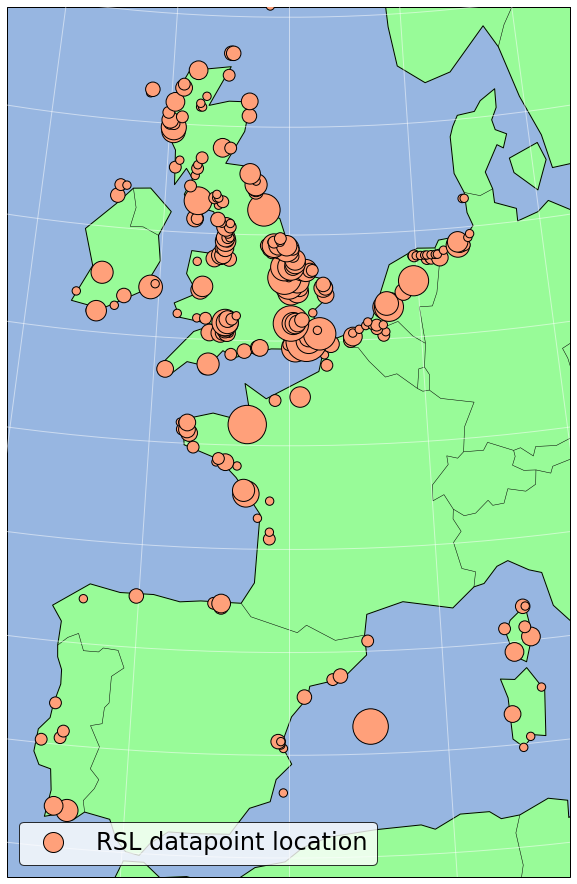

In [4]:
#get counts by location rounded to nearest 0.1 degree
df_rnd = df_place.copy()
df_rnd.lat = np.round(df_rnd.lat, 1)
df_rnd.lon = np.round(df_rnd.lon, 1)

dfcounts_place = df_rnd.groupby(['lat', 'lon']).count().reset_index()[['lat', 'lon', 'rsl', 'age']]

#plot
fig = plt.figure(figsize=(20, 16)) 
ax = plt.subplot(1, 1, 1, projection=ccrs.LambertConformal(central_longitude=0))

# extent = locs[place]
extent = [-10, 10, 35, 60]

ax.set_extent(extent)
ax.coastlines(resolution='110m', linewidth=1, zorder=2)
ax.add_feature(cfeature.OCEAN, zorder=0)
ax.add_feature(cfeature.LAND, color='palegreen', zorder=1)
ax.add_feature(cfeature.BORDERS, linewidth=0.5, zorder=3)  
ax.gridlines(linewidth=1, color='white', alpha=0.5, zorder=4)
scat = ax.scatter(dfcounts_place.lon, dfcounts_place.lat, s=dfcounts_place.rsl * 70, c = 'lightsalmon', 
                  vmin=-20, vmax=20, cmap='coolwarm', edgecolor='k', linewidths=1, 
                  transform=ccrs.PlateCarree(), zorder=5)
size = Line2D(range(4), range(4), color="black", marker='o', linewidth=0, linestyle='none',
              markersize=20, markerfacecolor="lightsalmon")
labels = ['RSL datapoint location']
leg = plt.legend([size], labels, loc='lower left', bbox_to_anchor=(0.00, 0.00), 
           prop={'size': 24}, fancybox=True)
leg.get_frame().set_edgecolor('k')
# ax.set_title('Holocene Relative Sea Level data: Europe', fontsize=26);
ax.set_title('')
# path = '/Users/rogercreel/Dropbox/Columbia_PhD/Research/Holocene/WAIS_readvance/notebooks/figs/'
path = '/Users/rogercreel/Dropbox/Columbia_PhD/classes/QMDA/final_project/figs/'
# plt.savefig(path + f'khan_rsldatabase_figure_120519_{place}',  transparent=True)
plt.show()

# Make 3D model of "true" fingerprint and fingerprint prior

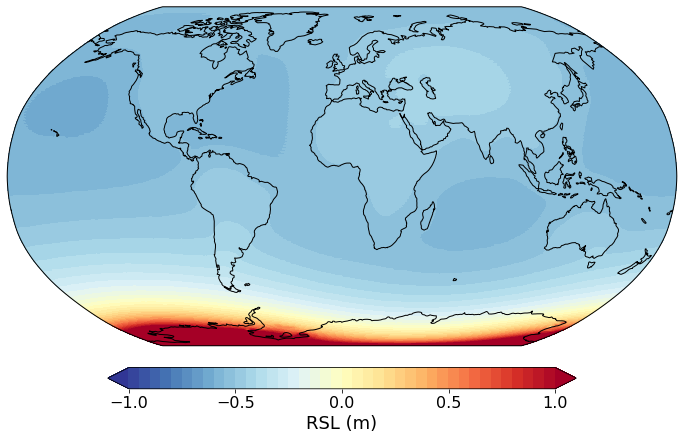

In [5]:
path = '/Users/rogercreel/Dropbox/Columbia_PhD/Research/Holocene/WAIS_readvance/notebooks/'
filename = 'WAISreadvance_VM5_6ka_1step.mat'
waismask = io.loadmat(path + filename, squeeze_me=True)
ds_mask = xr.Dataset({'rsl':  (['lat', 'lon', 'age'], waismask['RSL'])},
                        coords={'lon': waismask['lon_out'],
                        'lat': waismask['lat_out'],
                        'age': np.round(waismask['ice_time_new'])})

# fingerprint = ds_mask.rsl.transpose()[0].transpose()
fingerprint = ds_mask.sel(age=ds_mask.age[0])


# fingerprint['lon'] = np.concatenate([(fingerprint.lon.values[:256] - 180), fingerprint.lon.values[256:]-180])

fig, ax = plt.subplots(1, 1, figsize=(12, 8), subplot_kw=dict(projection=ccrs.Robinson()))
ax.coastlines()
ax1 = (-fingerprint).rsl.plot.contourf(ax=ax,vmin=-1, vmax=1, levels=41, cmap='RdYlBu_r',add_colorbar=False,
                                 transform=ccrs.PlateCarree(central_longitude=0), extend='both') 
                                      
cbar = fig.colorbar(ax1, shrink=.7, label='RSL (m)', ticks=[-1,-0.5, 0, 0.5, 1],
                    orientation='horizontal', pad=0.05)
cbar.ax.tick_params(labelsize=16)
cbar.set_label(label='RSL (m)', size=18)

# ax.set_title('Fingerprint of \n WAIS Readvance', fontsize=24)
ax.set_title('')

path = '/Users/rogercreel/Dropbox/Columbia_PhD/classes/QMDA/final_project/figs/'
plt.savefig(path + f'readvance_fingerprint_120719',  transparent=True)

#palindromic scaling vector
def palindrome(maxscale, ages):
    """ Make palindrome scale 0-maxval with number of steps. """
    half = np.linspace(0, maxscale, 1+(len(ages)-1)//2)
    scalefactor = np.concatenate([half, half[::-1]])
    return scalefactor


# Make deterministic readvance fingerprint

In [6]:
def make_fingerprint(start, end, maxscale):

    ages_lgm = np.arange(100,26000,tstep)[::-1]
    ages_readv = ages_lgm[(ages_lgm < start) & (ages_lgm >= end)]

    scale = palindrome(maxscale, ages_readv)

    #scale factor same size as ice model ages
    pre = np.zeros(np.where(ages_lgm == start)[0])
    post = np.zeros(len(ages_lgm) - len(pre) - len(scale))
    readv_scale = np.concatenate([pre, scale, post])

    #scale factor into dataarray
    da_scale = xr.DataArray(readv_scale, coords=[('age', ages_lgm)])

    # broadcast fingerprint & scale to same dimensions; 
    fingerprint_out, fing_scaled = xr.broadcast(fingerprint.rsl, da_scale)

    # mask fingerprint with scale to get LGM-pres timeseries
    ds_fingerprint = (fingerprint_out * fing_scaled).transpose().to_dataset(name='rsl')

    # scale dataset with fingerprint to LGM-present length & 0-max-0 over x years
    xrlist = []
    for i, key in enumerate(da_scale):
        mask = ds_fingerprint.sel(age=ds_fingerprint.age[i].values) * key
        mask = mask.assign_coords(scale=key, age=ages_lgm[i]).expand_dims(dim=['age'])
        xrlist.append(mask)
    ds_readv = xr.concat(xrlist, dim='age')
    
    ds_readv.coords['lon'] = pd.DataFrame((ds_readv.lon[ds_readv.lon >= 180] - 360)- 0.12) \
                            .append(pd.DataFrame(ds_readv.lon[ds_readv.lon < 180]) + 0.58) \
                            .reset_index(drop=True).squeeze()
    ds_readv = ds_readv.swap_dims({'dim_0':'lon'}).drop('dim_0')

    # Add readv to modeled RSL at locations with data 
    ##### Need to fix this, as currently slice does not acknowledge new coords #########
    ds_readv = ds_readv.sel(age=slice(tmax, tmin), 
                         lon=slice(df_place.lon.min() + 180 -2,df_place.lon.max() + 180 + 2),
                         lat=slice(df_place.lat.max() + 2 ,df_place.lat.min() - 2))
    return ds_readv

#readvance parameters
start, end = 6100, 3000
maxscale = 2.25

#make deterministic fingerprint
ds_readv = make_fingerprint(start, end, maxscale)

#readvance prior parameters
start, end = 8000, 2000
maxscale = 2.25
maxscale_ = '2_25'
ds_readvprior = make_fingerprint(start, end, maxscale)
ds_readvprior_std = ds_readvprior * 0.3

# Plot Readvance deterministic model and prior

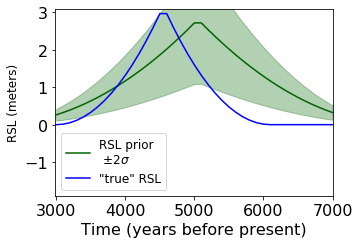

In [7]:
top = (ds_readvprior.rsl[:,0,0] + ds_readvprior_std.rsl[:,0,0] * 2).values
bottom = (ds_readvprior.rsl[:,0,0] - ds_readvprior_std.rsl[:,0,0] * 2).values

priorcolor = 'darkgreen'

fig, ax = plt.subplots(1,1,figsize=(5.1,3.5))
ds_readvprior.rsl[:,0,0].plot(ax=ax, label='RSL prior \n $\pm 2\sigma$', color=priorcolor)
ds_readv.rsl.mean(dim=['lat', 'lon']).plot(ax=ax, label='"true" RSL', color='blue')

ax.fill_between(ds_readvprior.age, top, bottom, alpha=0.3, color=priorcolor, )
# ax.set_title('"True" vs. prior', fontsize=18)

ax.set_xlim(tmin, tmax)
ax.set_ylabel('RSL (meters)', fontsize=12)
# ax.set_ylabel('', fontsize=12)

ax.set_xlabel('Time (years before present)', fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=16)
# ax.axes.get_xaxis().set_visible(False)
# ax.axes.get_yaxis().set_visible(False)
ax.legend(fontsize=12)
ax.set_ylim(-1.9, 3.1)
plt.tight_layout()

path = '/Users/rogercreel/Dropbox/Columbia_PhD/classes/QMDA/final_project/figs/'
plt.savefig(path + f'synthetic_readvance_timeseries_{maxscale_}_{priorcolor}120619',  transparent=True)

# Import GIA models & Build synthetic RSL datasets 

In [13]:
def build_dataset(model):
    """download model runs from local directory."""
    
    path = f'/Users/rogercreel/Dropbox/Columbia_PhD/Research/Holocene/WAIS_readvance/Cluster/output_ice/readv_out/output_readv/output_{model}'
    files = f'{path}*.nc'
    basefiles = glob.glob(files) 
    modelrun = [key.split('readv/output_', 1)[1][:-3].replace('.','_') for key in basefiles]
    dss = xr.open_mfdataset(files, chunks=None, concat_dim='modelrun', combine='nested')
    lats, lons, times = dss.LAT.values[0], dss.LON.values[0], dss.TIME.values[0]
    ds = dss.drop(['LAT', 'LON','TIME'])
    ds = ds.assign_coords(lat=lats, lon=lons, time=times, 
                          modelrun=modelrun).rename({'time':'age','RSL':'rsl'})
    return ds

def one_mod(names):
    """Organize model runs into xarray dataset."""
    ds1 = build_dataset(names[0])
    names = names[1:]
    ds = ds1.chunk({'lat':10, 'lon':10})
    for i in range(len(names)):
        temp = build_dataset(names[i])
        temp1 = temp.interp_like(ds1)
        temp1['modelrun']=temp['modelrun']
        ds = xr.concat([ds, temp1], dim='modelrun')
    ds['age'] = ds['age'] * 1000
    ds = ds.roll(lon=256, roll_coords=True)
    ds.coords['lon'] = pd.DataFrame((ds.lon[ds.lon >= 180] - 360)- 0.12 ) \
                            .append(pd.DataFrame(ds.lon[ds.lon < 180]) + 0.58) \
                            .reset_index(drop=True).squeeze()
    ds = ds.swap_dims({'dim_0':'lon'}).drop('dim_0')
    return ds

#import many GIA models
ds = one_mod([ice_model+lith_thickness])

#make composite of a bunch of GIA runs, i.e. GIA prior
ds = one_mod([ice_model+lith_thickness])
ds_sliced = ds.rsl.sel(age=slice(tmax, tmin), lon=slice(df_place.lon.min() - 2, df_place.lon.max() + 2),
          lat=slice(df_place.lat.max() + 2, df_place.lat.min() - 2))
ds_area = ds_sliced.mean(dim='modelrun').load().to_dataset().interp(age=ds_readv.age,
                                                                      lon=ds_readv.lon,
                                                                      lat=ds_readv.lat)
ds_areastd = ds_sliced.std(dim='modelrun').load().to_dataset().interp(age=ds_readv.age,
                                                                         lon=ds_readv.lon,
                                                                         lat=ds_readv.lat)

# make "true" RSL by adding single GIA run and fingerprint
lithmantle = 'l71C_ump2_lm50'
ds_diff = one_mod([ice_model+'l71C']).sel(modelrun=ice_model+lithmantle).rsl.sel(age=slice(tmax, tmin), 
                     lon=slice(df_place.lon.min() - 2,df_place.lon.max() + 2),
                     lat=slice(df_place.lat.max() + 2,df_place.lat.min() - 2)).load().to_dataset().interp(age=ds_readv.age, 
                                                                                                      lon=ds_readv.lon,
                                                                                                     lat=ds_readv.lat)
#make residual by subtracting GIA prior and fingerprint prior from "true" GIA 
ds_true = ds_diff + ds_readv
ds_prior = ds_area + ds_readvprior
ds_priorstd = ds_areastd + ds_readvprior_std
ds_truelessprior = ds_true - ds_prior

#sample each model at points where we have RSL data
def ds_select(ds):
    return ds.rsl.sel(age=[row.age], lon=[row.lon], lat=[row.lat], method='nearest').squeeze().values
    

#select points at which RSL data exists
for i, row in df_place.iterrows():
    df_place.loc[i, 'rsl_true'] = ds_select(ds_true)
    df_place.loc[i, 'rsl_realresid'] = df_place.rsl[i] - ds_select(ds_area)
    df_place.loc[i, 'rsl_resid'] = ds_select(ds_truelessprior)
    df_place.loc[i, 'rsl_totalprior'] = ds_select(ds_prior)
    df_place.loc[i, 'rsl_totalprior_std'] = ds_select(ds_priorstd)
    df_place.loc[i, 'rsl_giaprior'] = ds_select(ds_area)
    df_place.loc[i, 'rsl_giaprior_std'] = ds_select(ds_areastd)
    df_place.loc[i, 'rsl_readvprior'] = ds_select(ds_readvprior)
    df_place.loc[i, 'rsl_readvprior_std'] = ds_select(ds_readvprior_std)

    
# #perturb rsl_resid with gaussian uncertainties
# for i, row in df_place.iterrows():
#     noise = gauss(0, row.rsl_er_max)
#     df_place.loc[i, 'rsl_resid'] = row.rsl_true_nonoise + noise
#     df_place.loc[i, 'rsl_true'] = row.rsl_resid_nonoise + noise
df_place.head()

,lat,lon,rsl,rsl_er_max,age,rsl_true,rsl_realresid,rsl_resid,rsl_totalprior,rsl_totalprior_std,rsl_giaprior,rsl_giaprior_std,rsl_readvprior,rsl_readvprior_std
index,,,,,,,,,,,,,,
3007,37.06,-8.08,-0.350,0.933,2990,-1.480952,0.531531,-0.887856,-0.593096,0.585849,-0.881531,0.499319,0.288435,0.086530
3008,43.32,-2.68,-2.502,0.609,2998,-0.942396,-1.721832,-0.451020,-0.491376,0.612112,-0.780168,0.525475,0.288792,0.086638
3009,43.34,-2.67,-3.645,1.221,3009,-0.942396,-2.864832,-0.451020,-0.491376,0.612112,-0.780168,0.525475,0.288792,0.086638
3010,43.36,-2.67,-2.557,0.546,3021,-0.942396,-1.776832,-0.451020,-0.491376,0.612112,-0.780168,0.525475,0.288792,0.086638
3011,47.59,-3.05,-0.970,2.722,3056,-2.337581,0.977907,-0.743856,-1.593725,0.669433,-1.947907,0.563179,0.354182,0.106255


# Add 3D fingerprint of readvance

In [14]:
# save so we only have to do it once
def save_dataframe(df_out, path, run, place):
    """save filename to directory, compete path specified"""
    filename = f'{path}{run}_{place}_fingerprint.csv'
    df_out.sort_index().to_csv(filename, index=False)
    return True
path = '/Users/rogercreel/Dropbox/Columbia_PhD/classes/QMDA/final_project/'
run='l96C_andVM5VM5'
save_dataframe(df_place, path, run, place)

path = '/Users/rogercreel/Dropbox/Columbia_PhD/classes/QMDA/final_project/'

def read_dataframe(path, run, place):
    """read filename from directory, compete path specified"""
    filename = f'{path}{run}_{place}_fingerprint.csv'
    file = pd.read_csv(filename)
    return file
df_place = read_dataframe(path, run, place)

df_place = df_place[(df_place.lon > extent[0] - 2) & (df_place.lon < extent[1] + 2) 
                  & (df_place.lat > extent[2] - 2) & (df_place.lat < extent[3] + 2)
                  & (df_place.age < tmax) & (df_place.age > tmin)]
df_place.shape

(1019, 14)

# Run GP regression

In [15]:
from gpflow.logdensities import multivariate_normal
from gpflow.kernels import Kernel
from gpflow.mean_functions import MeanFunction
from typing import Optional, Tuple, List
from gpflow.utilities import set_trainable
Data = Tuple[tf.Tensor, tf.Tensor]
likelihood = df_place.rsl_er_max.ravel()**2 + df_place.rsl_giaprior_std.ravel()**2  # here we define likelihood

class GPR_diag(gpf.models.GPModel):
    """
    Gaussian Process Regression.
    This is a vanilla implementation of GP regression with a pointwise Gaussian
    likelihood.  Multiple columns of Y are treated independently.
    The log likelihood of this models is sometimes referred to as the 'marginal log likelihood',
    and is given by
    .. math::
       \log p(\mathbf y \,|\, \mathbf f) =
            \mathcal N\left(\mathbf y\,|\, 0, \mathbf K + \sigma_n \mathbf I\right)
    """

    def __init__(self, data: Data, kernel: Kernel, mean_function: Optional[MeanFunction] = None,
                 likelihood = likelihood):
        likelihood = gpf.likelihoods.Gaussian(variance=likelihood)
        _, y_data = data
        super().__init__(kernel, likelihood, mean_function, num_latent=y_data.shape[-1])
        self.data = data

    def log_likelihood(self):
        r"""
        Computes the log likelihood.
        .. math::
            \log p(Y | \theta).
        """
        x, y = self.data
        K = self.kernel(x)
        num_data = x.shape[0]
        k_diag = tf.linalg.diag_part(K)
        s_diag = tf.convert_to_tensor(self.likelihood.variance)
        ks = tf.linalg.set_diag(K, k_diag + s_diag)
        L = tf.linalg.cholesky(ks)
        m = self.mean_function(x)

        # [R,] log-likelihoods for each independent dimension of Y
        log_prob = multivariate_normal(y, m, L)
        return tf.reduce_sum(log_prob)

    def predict_f(self, predict_at: tf.Tensor, full_cov: bool = False, full_output_cov: bool = False):
        r"""
        This method computes predictions at X \in R^{N \x D} input points
        .. math::
            p(F* | Y)
        where F* are points on the GP at new data points, Y are noisy observations at training data points.
        """
        x_data, y_data = self.data
        err = y_data - self.mean_function(x_data)

        kmm = self.kernel(x_data)
        knn = self.kernel(predict_at, full=full_cov)
        kmn = self.kernel(x_data, predict_at)

        num_data = x_data.shape[0]
        s = tf.linalg.diag(tf.convert_to_tensor(self.likelihood.variance)) #changed from normal GPR

        conditional = gpf.conditionals.base_conditional
        f_mean_zero, f_var = conditional(kmn, kmm + s, knn, err, full_cov=full_cov,
                                         white=False)  # [N, P], [N, P] or [P, N, N]
        f_mean = f_mean_zero + self.mean_function(predict_at)
        return f_mean, f_var
    
def normalize(df):
    return np.array((df - df.mean()) / df.std()).reshape(len(df), 1)

def denormalize(y_pred, df):
    return np.array((y_pred * df.std()) + df.mean())

def bounded_lengthscale(low, high, lengthscale):
    """Make lengthscale tfp Parameter with optimization bounds."""
    affine = tfb.AffineScalar(shift=low, scale=(high - low))
    sigmoid = tfb.Sigmoid()
    logistic = tfb.Chain([affine, sigmoid])
    parameter = gpf.Parameter(lengthscale, transform=logistic, dtype=tf.float32)
    parameter = tf.cast(parameter, dtype=tf.float64)
    return parameter

###########||||||||||||||||||||||||######################
#                                                       #
#              Section to Run GPR                       #
#                                                       #
##########|||||||||||||||||||||||||######################

# Input space, rsl normalized to zero mean, unit variance
X = np.stack((df_place['lon'], df_place['lat'], df_place['age']), 1)
RSL = normalize(df_place.rsl_realresid)

#define kernel 
k1 = gpf.kernels.Matern32(active_dims=[0,1], lengthscale=5)      #GIA space 
k2 = gpf.kernels.Matern32(active_dims=[2], lengthscale = 9000)  #GIA time 
# k3 = gpf.kernels.Matern32(active_dims=[0,1], lengthscale=50)     #hemispheric space
k4 = gpf.kernels.Matern32(active_dims=[2], lengthscale=2000)     #shorter time

# set bounds on kernel lengthscales
k1.lengthscale.assign(bounded_lengthscale(1, 10, 6))
k2.lengthscale.assign(bounded_lengthscale(6000, 38000, 9900))
# k3.lengthscale.assign(bounded_lengthscale(10,100, 50))
k4.lengthscale.assign(bounded_lengthscale(500,6000, 2000))


kernel =  k1 + k2 + k4

#build & train model 
m = GPR_diag((X, RSL), kernel=kernel, likelihood=likelihood) 

#choose whether to set variance as trainable or not
# set_trainable(m.likelihood.variance, False)

@tf.function(autograph=False)
def objective():
    return m.neg_log_marginal_likelihood()
o = gpf.optimizers.Scipy()
o.minimize(objective, variables=m.trainable_variables)

# output space
nout= 50
lat = np.linspace(min(ds_area.lat), max(ds_area.lat), nout)
lon = np.linspace(min(ds_area.lon), max(ds_area.lon), nout)
ages = ages_lgm[(ages_lgm < tmax) & (ages_lgm > tmin)]
xyt = np.array(list(product(lon, lat, ages)))

#query model & renormalize data
y_pred, var = m.predict_f(xyt)
y_pred_out = denormalize(y_pred, df_place.rsl_resid)

#reshape output vectors
Xlon = np.array(xyt[:,0]).reshape((nout,nout, len(ages))) 
Xlat = np.array(xyt[:,1]).reshape((nout,nout, len(ages)))        
Zp = np.array(y_pred_out).reshape(nout,nout, len(ages))
varp = np.array(var).reshape(nout,nout,len(ages))

#print kernel details
# gpf.config.set_default_summary_fmt("notebook")
print_summary(m, fmt='notebook')
print_summary(k1, fmt='notebook')
print_summary(k2, fmt='notebook')
# print_summary(k3, fmt='notebook')
print_summary(k4, fmt='notebook')

Instructions for updating:
`AffineScalar` bijector is deprecated; please use `tfb.Shift(loc)(tfb.Scale(...))` instead.


KeyboardInterrupt: 

# Interpolate all models onto GPR grid

In [422]:
# turn GPR output into xarray dataarray
da_zp = xr.DataArray(Zp, coords=[lon, lat, ages],
                     dims=['lon', 'lat', 'age']).transpose('age','lat', 'lon')
da_varp = xr.DataArray(varp, coords=[lon, lat, ages],
                     dims=['lon', 'lat', 'age']).transpose('age','lat', 'lon')

def interp_likegpr(ds):
    return ds.rsl.load().transpose().interp_like(da_zp)

#interpolate all models onto GPR grid
da_trueinterp = interp_likegpr(ds_true)
ds_trueinterp = ds_true.interp(age=ages)
da_priorinterp = interp_likegpr(ds_prior)
ds_priorinterp = ds_prior.interp(age=ages)
da_priorinterpstd = interp_likegpr(ds_priorstd)
da_giapriorinterp = interp_likegpr(ds_area)
ds_giapriorinterp = ds_area.interp(age=ages)
da_giapriorinterpstd = interp_likegpr(ds_areastd)
da_readvpriorinterp = interp_likegpr(ds_readvprior)
da_readvpriorinterpstd = interp_likegpr(ds_readvprior_std)

# add total prior RSL back into GPR
da_priorplusgpr = da_zp + da_giapriorinterp

# Plot composite kernels

In [423]:
extent_

[-11.6, 10.6, 35.1, 61.4]

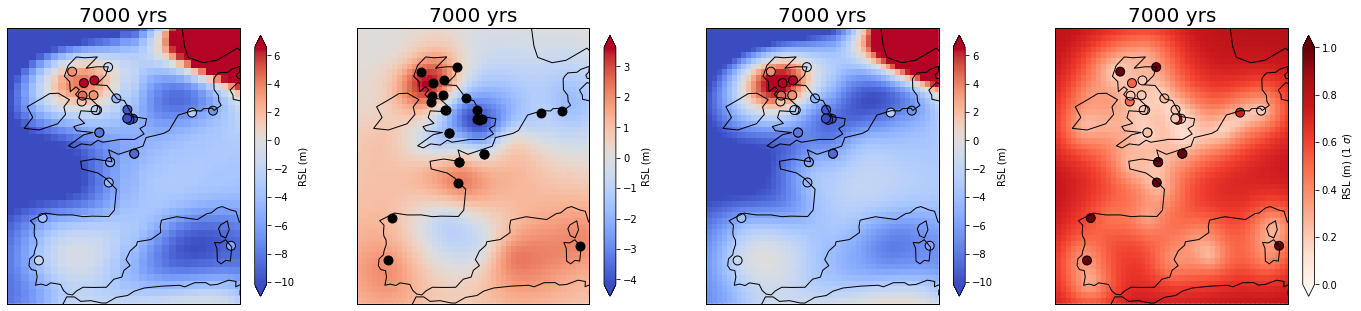

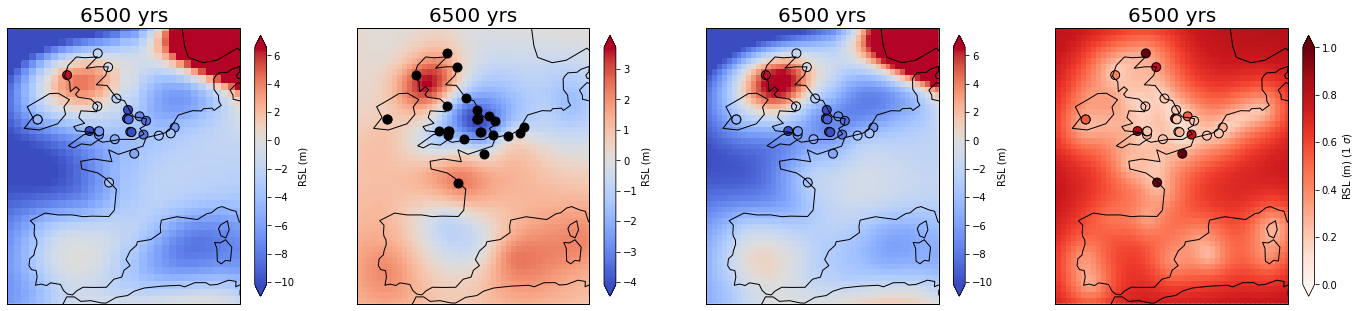

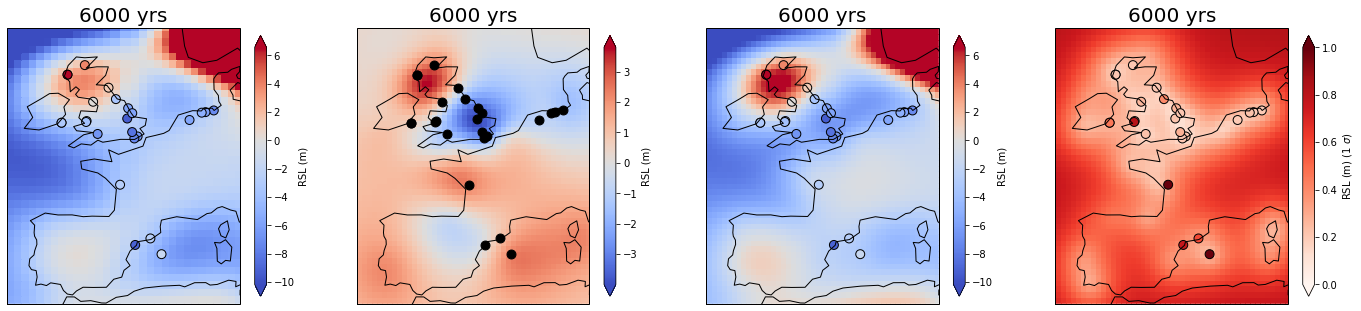

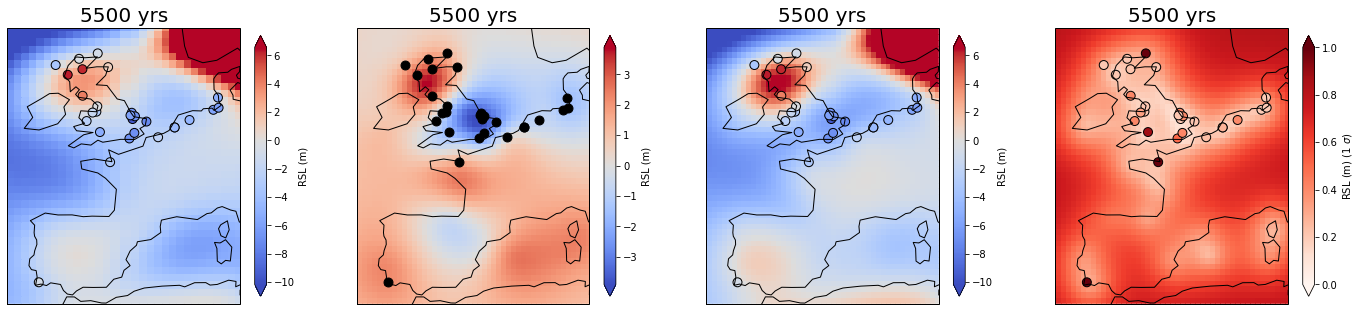

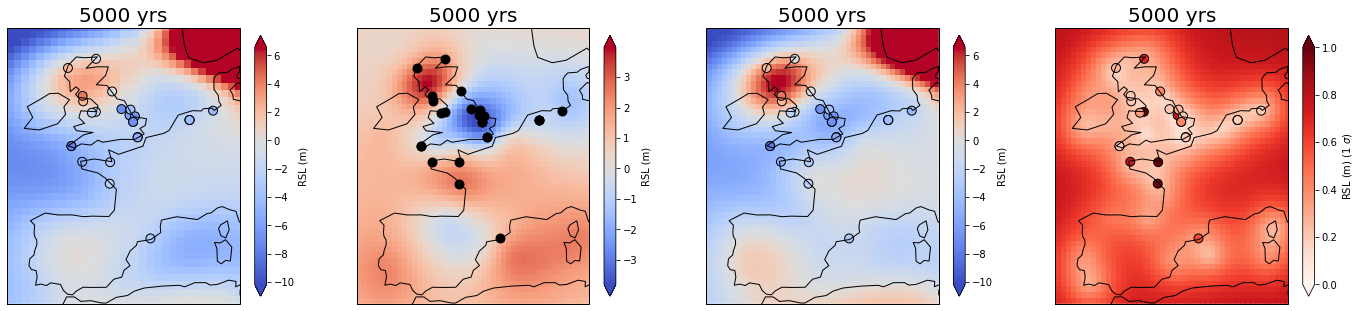

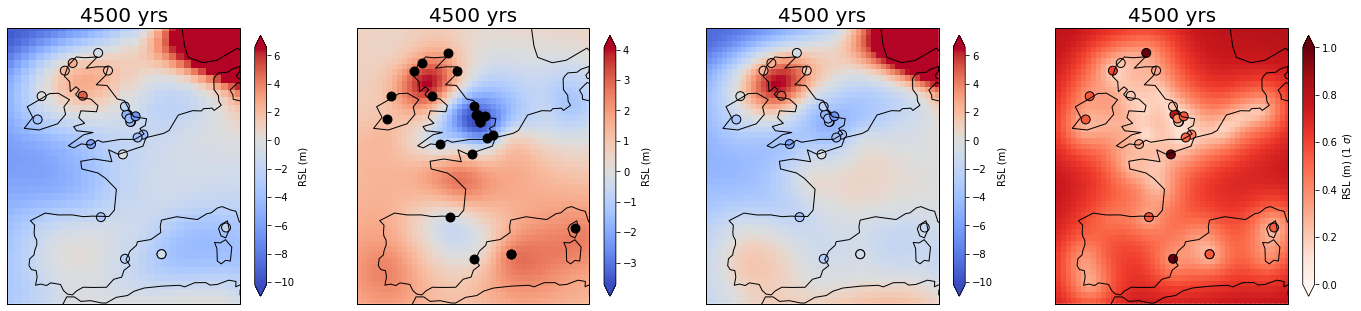

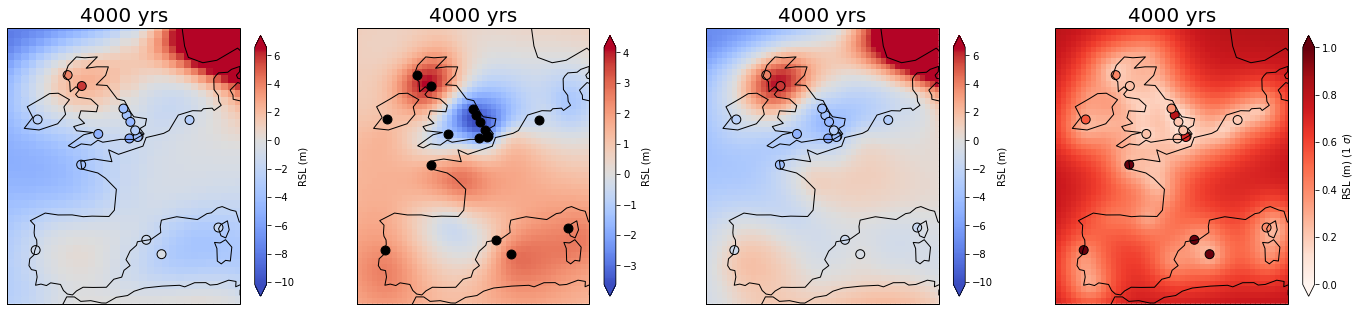

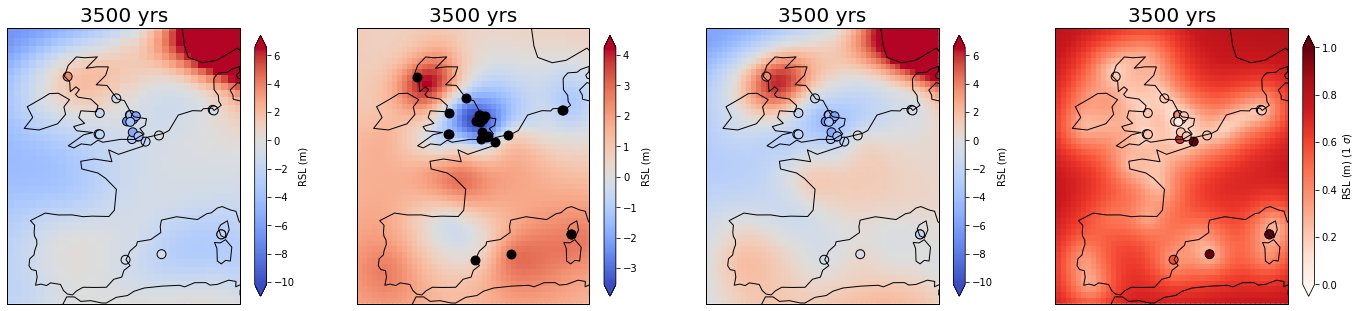

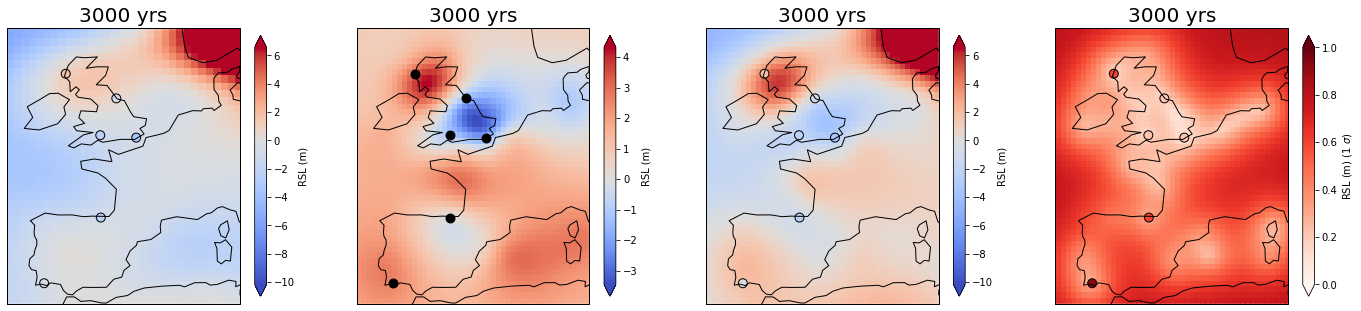

In [429]:
extent_ = [extent[0]-1.6, extent[1]+0.6, extent[2]+0.1, extent[3]+1.4]
for i, age in enumerate(ages):
    if (age/500).is_integer():
        step = (ages[0] - ages[1])
        df_it = df_place[(df_place.age < age) & (df_place.age > age - step)]
        resid_it = da_zp.sel(age=slice(age, age - step))
#         ds_it = ds_trueinterp.sel(age=slice(age, age - step))
        rsl, var = df_it.rsl, df_it.rsl_er_max.values**2 
        lat_it, lon_it = df_it.lat, df_it.lon
        vmin = ds_giapriorinterp.rsl.min().values + 10
        vmax = ds_giapriorinterp.rsl.max().values - 60
        vmin_std = 0
        vmax_std = 1
        tmin_it = np.round(age - step, 2)
        tmax_it = np.round(age, 2)
        cbarscale = 0.3
        fontsize=20
        cmap = 'coolwarm' 
        cbar_kwargs = {'shrink': cbarscale,'label':'RSL (m)'}

        proj = ccrs.PlateCarree()
        projection = ccrs.PlateCarree()
        fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(24, 16), subplot_kw=dict(projection=projection))

        # total prior mean + "true" data
        ax1.coastlines(color='k')
        pc1 = ds_giapriorinterp.rsl[i].transpose().plot(ax=ax1, transform=proj, cmap=cmap, 
                                                    norm=MidpointNormalize(vmin, vmax, 0),
                                                    add_colorbar=False, extend='both')
        cbar = fig.colorbar(pc1, ax=ax1, shrink=.3, label='RSL (m)', extend='both')
        scat = ax1.scatter(lon_it, lat_it, s=80, c=rsl, edgecolor='k', vmin=vmin, vmax=vmax,
                           norm=MidpointNormalize(vmin, vmax, 0),cmap=cmap)
        ax1.set_title(f'{np.round(ds_trueinterp.rsl[i].age.values, -1)} yrs', fontsize=fontsize)    
        ax1.set_extent(extent_)         


        # Learned difference between prior and "true" data
        ax2.coastlines(color='k')
        pc = da_zp[i,:,:].plot(ax=ax2,
                               transform=proj,
                               cmap=cmap, 
                               extend='both',
                               norm=MidpointNormalize(resid_it.min(), resid_it.max(), 0),
                               add_colorbar=False
                              )
        cbar = fig.colorbar(pc,
                            ax=ax2, 
                            shrink=.3, 
                            label='RSL (m)',
                            extend='both'
                           )
        scat = ax2.scatter(lon_it, lat_it, s=80, 
                           facecolors='k',
                           cmap=cmap, 
                           edgecolor='k', 
                           transform=proj,
                           norm=MidpointNormalize(resid_it.min(), resid_it.max(), 0)
                          )
        ax2.set_title(f'{np.round(tmax_it,2)} yrs', fontsize=fontsize); 
        ax2.set_extent(extent_)
    
        # GP regression 
        ax3.coastlines(color='k')
        pc = da_priorplusgpr[i].plot(ax=ax3, transform=proj,
                                     norm=MidpointNormalize(vmin, vmax, 0),
                                     cmap=cmap, extend='both',
                                     add_colorbar=False
                                    )
        scat = ax3.scatter(lon_it, lat_it, s=80, c=rsl, edgecolor='k', cmap=cmap,
                           norm=MidpointNormalize(vmin, vmax, 0))
        cbar = fig.colorbar(pc, ax=ax3,
                            shrink=.3, 
                            label='RSL (m)',
                            extend='both')
        ax3.set_title(f'{np.round(tmax_it,2)} yrs', fontsize=fontsize);
        ax3.set_extent(extent_)
        
        #GP regression standard deviation
        ax4.coastlines(color='k')
        pc = np.sqrt(da_varp[i]).plot(ax=ax4, transform=proj,
                                      vmin=vmin_std, 
                                      vmax=vmax_std, 
                                      cmap='Reds',  
                                      extend='both',
                                      add_colorbar=False,
                                 )
        scat = ax4.scatter(lon_it, lat_it, s=80, c=np.sqrt(var), vmin=vmin_std, vmax=vmax_std,
                           cmap='Reds', edgecolor='k', transform=proj)
        cbar = fig.colorbar(pc, ax=ax4,
                            shrink=.3, 
                            extend='both',
                            label='RSL (m) (1 $\sigma$)'
                           )
        ax4.set_title(f'{np.round(tmax_it,2)} yrs', fontsize=fontsize); 
        ax4.set_extent(extent_)
        
#         path = '/Users/rogercreel/Dropbox/Columbia_PhD/Research/Holocene/WAIS_readvance/notebooks/figs/'

        path = '/Users/rogercreel/Dropbox/Columbia_PhD/classes/QMDA/final_project/figs/'
        run='d6g_h6g_l96C_andVM5VM5'
        fig.savefig(path + f'{run}_{place}_{age}_realrsl_bare_fig', transparent=True)

In [338]:
def  locs_with_enoughsamples(df_place, place, number):
    """make new dataframe, labeled, of sites with [> number] measurements"""
    df_lots = df_place.groupby(['lat', 'lon']).filter(lambda x:len(x) > number)

    df_locs=[]
    for i, group in enumerate(df_lots.groupby(['lat', 'lon'])):
        singleloc = group[1].copy()
        singleloc['location'] = place
        singleloc['locnum'] = place + '_site' + str(i) # + singleloc.reset_index().index.astype('str')
        df_locs.append(singleloc)
    df_locs = pd.concat(df_locs)
    
    return df_locs
    
number=7
df_nufsamps = locs_with_enoughsamples(df_place, place, number)
len(df_nufsamps.locnum.unique())

9

# Plot those locations

/anaconda3/envs/gpflow5_0/lib/python3.7/site-packages/ipykernel_launcher.py:53: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 


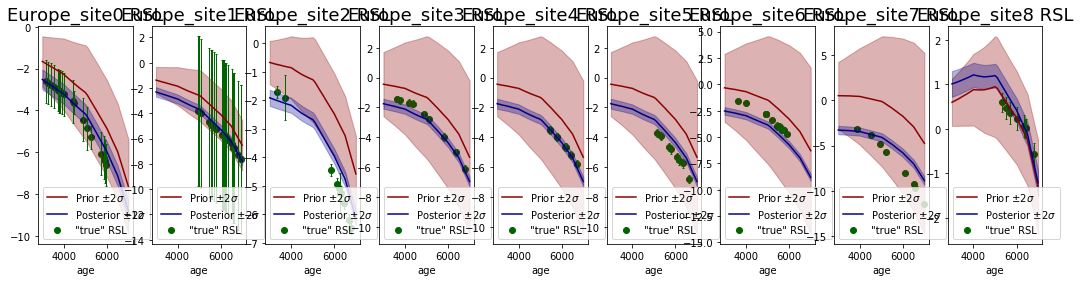

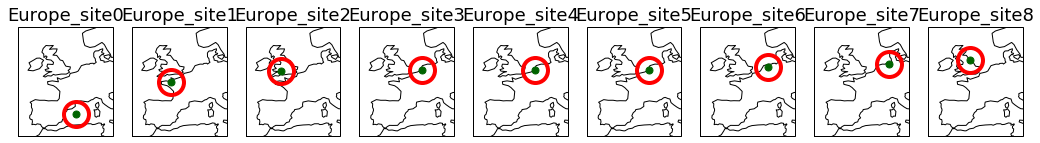

In [339]:
def slice_dataarray(da):
    return da.sel(lat=site[1].lat.unique(), lon=site[1].lon.unique(), method='nearest')

fig, ax = plt.subplots(1, len(df_nufsamps.locnum.unique()), figsize=(18, 4))
ax = ax.ravel()
colors =['darkgreen', 'darkblue', 'darkred']
fontsize=18

for i, site in enumerate(df_nufsamps.groupby('locnum')):
    
    #slice data for each site
    prior_it = slice_dataarray(da_priorinterp)
    priorvar_it = slice_dataarray(da_priorinterpstd)
    top_prior = prior_it + priorvar_it * 2
    bottom_prior = prior_it - priorvar_it * 2
    
    var_it = slice_dataarray(np.sqrt(da_varp))
    post_it = slice_dataarray(da_priorplusgpr)
    top = post_it + var_it * 2
    bottom = post_it - var_it * 2
    
    
    ax[i].scatter(site[1].age, site[1].rsl_true, c=colors[0], label='"true" RSL')
    ax[i].errorbar(site[1].age, site[1].rsl_true, site[1].rsl_er_max, c=colors[0], fmt='none', 
                   capsize=1, lw=1,)
    
    prior_it.plot(ax=ax[i], c=colors[2], label='Prior $\pm 2 \sigma$')
    ax[i].fill_between(prior_it.age, bottom_prior.squeeze(), top_prior.squeeze(), color=colors[2], alpha=0.3)

    post_it.plot(ax=ax[i], c=colors[1], label='Posterior $\pm 2 \sigma$')
    ax[i].fill_between(post_it.age, bottom.squeeze(), top.squeeze(), color=colors[1], alpha=0.3)
    ax[i].set_title(f'{site[0]} RSL', fontsize=fontsize)
    ax[i].legend(loc='lower left')
    
path = '/Users/rogercreel/Dropbox/Columbia_PhD/classes/QMDA/final_project/figs/'
# fig.savefig(path + f'{run}_{ages[0]}to{ages[-1]}_{place}_giaplusreadvmodel_fig', transparent=True)

#plot locations of data 
fig, ax = plt.subplots(1, len(df_nufsamps.locnum.unique()), 
                       figsize=(18, 4), subplot_kw=dict(projection=projection))
ax = ax.ravel()

da_zeros = xr.zeros_like(da_zp)

for i, site in enumerate(df_nufsamps.groupby('locnum')):
    ax[i].coastlines(color='k')
    ax[i].plot(site[1].lon.unique(),site[1].lat.unique(),
         c=colors[0], ms=7, marker='o', transform=proj)
    ax[i].plot(site[1].lon.unique(),site[1].lat.unique(), c=colors[0], 
               ms=25, marker='o', transform=proj, mfc="None", mec='red', mew=4)
    da_zeros[0].plot(ax=ax[i], cmap='Greys', add_colorbar=False)
    ax[i].set_title(site[0], fontsize=fontsize)
plt.tight_layout()
# fig.savefig(path + f'{run}_{ages[0]}to{ages[-1]}_{place}_location_fig', transparent=True, bbox_inches = 'tight')

# Plot locations in  

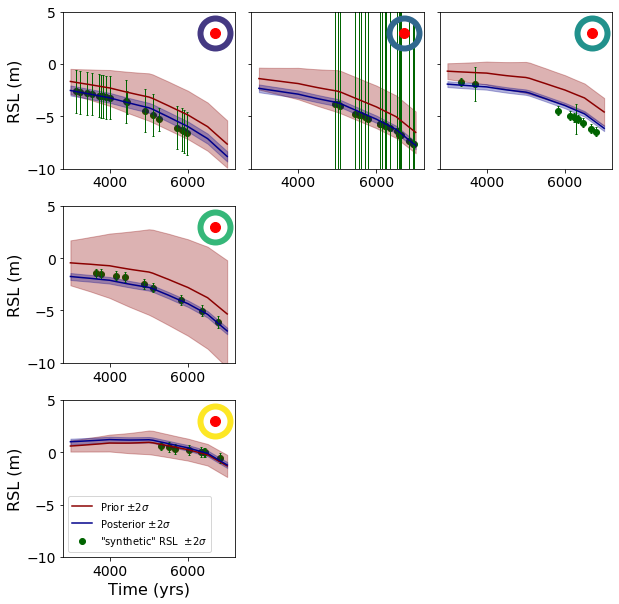

In [359]:
fig, ax = plt.subplots(3, 3, figsize=(8.7, 8.5), sharey=True) #int(len(df_nufsamps.locnum.unique()) )
ax = ax.ravel()
colors_ =['darkgreen', 'darkblue', 'darkred']
fontsize=18
sites = ['site 1', 'site 2', 'site 3', 'site 4', 'site 5', 'site 6']
locs = ['Europe_site0', 'Europe_site1', 'Europe_site2', 
        'Europe_site10', 'Europe_site11', 'Europe_site12']

#get viridis colormaps
from matplotlib import colors
cmap = cm.get_cmap('viridis', 7) 
hexcodes = []
for i in range(cmap.N): 
    hexcodes.append(colors.rgb2hex(cmap(i)[:3]))
hexcodes = hexcodes[1:]


for i, site in enumerate(df_nufsamps.groupby('locnum')):
    #slice data for each site
    prior_it = slice_dataarray(da_priorinterp)
    priorvar_it = slice_dataarray(da_priorinterpstd)
    top_prior = prior_it + priorvar_it * 2
    bottom_prior = prior_it - priorvar_it * 2

    var_it = slice_dataarray(np.sqrt(da_varp))
    post_it = slice_dataarray(da_priorplusgpr)
    top = post_it + var_it * 2
    bottom = post_it - var_it * 2

    rect1 = Rectangle((1,1),100,10,linewidth=1,edgecolor='r')
    if  i < 4:  
        ax[i].scatter(site[1].age, site[1].rsl_true, c=colors_[0], label='"true" RSL')
        ax[i].errorbar(site[1].age, site[1].rsl_true, 2*site[1].rsl_er_max, c=colors_[0], fmt='none', 
                       capsize=1, lw=1,)

        prior_it.plot(ax=ax[i], c=colors_[2], label='Prior $\pm 2 \sigma$')
        ax[i].fill_between(prior_it.age, bottom_prior.squeeze(), top_prior.squeeze(), color=colors_[2], alpha=0.3)

        post_it.plot(ax=ax[i], c=colors_[1], label='Posterior $\pm 2 \sigma$')
        ax[i].fill_between(post_it.age, bottom.squeeze(), top.squeeze(), color=colors_[1], alpha=0.3)
#         ax[i].set_title(f'{site[0]} RSL', fontsize=fontsize)
        ax[i].set_title('')
#         ax[i].legend(loc='lower left')
        ax[i].plot(6700, 3, 'o', ms=30, marker='o', mfc="None", mec=hexcodes[i], mew=6)
        ax[i].plot(6700, 3, c='r', ms=10, marker='o')
        ax[i].add_artist(rect1)
        ax[i].tick_params(axis='both', which='major', labelsize=14)
        ax[i].set_xlabel('')
        ax[i].set_ylim(-10, 5)

#     if i < 1:
#         ax[i].axes.get_xaxis().set_visible(False)
    if i == 0:
        ax[i].set_ylabel('RSL (m)', fontsize=16)
    if i == 3:
        ax[i].set_ylabel('RSL (m)', fontsize=16)
#         ax[i].axes.get_xaxis().set_visible(False)
    if i == 1:
        ax[i].tick_params(axis='both', which='major', labelsize=14)
    if i == 2:
        ax[i].tick_params(axis='both', which='major', labelsize=14)
    if i == 4:
        ax[i].axes.set_visible(False)
    if i == 5:
        ax[i].axes.set_visible(False)
    if i == 7:
        ax[i].axes.set_visible(False)
    if i == 8:
        ax[i].axes.set_visible(False)

    
    if i == 8:
        ax[6].scatter(site[1].age, site[1].rsl_true, c=colors_[0], label='"synthetic" RSL  $\pm 2 \sigma$')
        ax[6].errorbar(site[1].age, site[1].rsl_true, 2*site[1].rsl_er_max, c=colors_[0], fmt='none', 
                       capsize=1, lw=1,)

        prior_it.plot(ax=ax[6], c=colors_[2], label='Prior $\pm 2 \sigma$')
        ax[6].fill_between(prior_it.age, bottom_prior.squeeze(), top_prior.squeeze(), color=colors_[2], alpha=0.3)

        post_it.plot(ax=ax[6], c=colors_[1], label='Posterior $\pm 2 \sigma$')
        ax[6].fill_between(post_it.age, bottom.squeeze(), top.squeeze(), color=colors_[1], alpha=0.3)
#         ax[5].set_title(f'{site[0]} RSL', fontsize=fontsize)
        ax[6].set_title('')
        ax[6].legend(loc='lower left', fontsize=10)
        ax[6].plot(6700, 3, 'o', ms=30, marker='o', mfc="None", mec=hexcodes[5], mew=6)
        ax[6].plot(6700, 3, c='r', ms=10, marker='o')
        ax[6].add_artist(rect1)
        ax[6].tick_params(axis='both', which='major', labelsize=14)
        ax[6].set_xlabel('Time (yrs)', fontsize=16)
        ax[6].set_ylabel('RSL (m)', fontsize=16)
        ax[6].set_ylim(-10, 5)

plt.tight_layout()
fig.savefig(path + f'{run}_{ages[0]}to{ages[-1]}_{place}_locations_square_fig', transparent=True, bbox_inches = 'tight')

In [341]:
#get viridis colormaps
from matplotlib import colors
cmap = cm.get_cmap('viridis', 7) 
hexcodes = []
for i in range(cmap.N): 
    hexcodes.append(colors.rgb2hex(cmap(i)[:3]))
    
hexcodes.pop(4)

'#35b779'

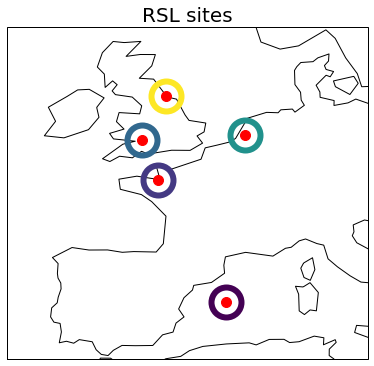

In [342]:
fig, ax = plt.subplots(1, 1, figsize=(6.8, 6.1), subplot_kw=dict(projection=projection))

da_zeros = xr.zeros_like(da_zp)[:,3:43,:]
ax.coastlines(color='k')

for i, site in enumerate(df_nufsamps.groupby('locnum')):
    if  i < 4:
        ax.plot(site[1].lon.unique(),site[1].lat.unique(),
                    c='r', ms=10, marker='o', transform=proj)
        ax.plot(site[1].lon.unique(),site[1].lat.unique(), 
               ms=30, marker='o', transform=proj, mfc="None", mec=hexcodes[i], mew=6)
        da_zeros[0].plot(ax=ax, cmap='Greys', add_colorbar=False)
    if  i == 8:
#         if i < 7:
        ax.plot(site[1].lon.unique(),site[1].lat.unique(),
                    c='r', ms=10, marker='o', transform=proj)
        ax.plot(site[1].lon.unique(),site[1].lat.unique(), 
               ms=30, marker='o', transform=proj, mfc="None", mec=hexcodes[5], mew=6)
        da_zeros[0].plot(ax=ax, cmap='Greys', add_colorbar=False)
ax.set_title('RSL sites', fontsize=20)
fig.savefig(path + f'{run}_{ages[0]}to{ages[-1]}_{place}_locationsmap_fig', transparent=True, bbox_inches = 'tight')

# Decompose GPR into kernels

In [343]:
def predict_decomp_f(m, custom_kernel, predict_at: tf.Tensor, full_cov: bool = False,
                 full_output_cov: bool = False, var=None):
    """Decompose GP into individual kernels."""
    
    x_data, y_data = m.data
    err = y_data - m.mean_function(x_data)
    kmm = m.kernel(x_data)
    knn = custom_kernel(predict_at, full=full_cov)
    kmn = custom_kernel(x_data, predict_at)
    num_data = x_data.shape[0]
    s = tf.linalg.diag(tf.convert_to_tensor(var)) # added diagonal variance 
    conditional = gpf.conditionals.base_conditional
    f_mean_zero, f_var = conditional(kmn, kmm + s, knn, err, full_cov=full_cov,
                                    white=False)  # [N, P], [N, P] or [P, N, N]
    f_mean = np.array(f_mean_zero + m.mean_function(predict_at))
    f_var = np.array(f_var)
    return f_mean, f_var

def reshape_decomp(k, var=None):
    A, var = predict_decomp_f(m, k, xyt, var=var)
    A = A.reshape(nout, nout, len(ages))
    var = var.reshape(nout, nout, len(ages))
    return A, var

def make_dataarray(da):
    coords = [lon, lat, ages]
    dims = ['lon', 'lat', 'age']
    return xr.DataArray(da, coords=coords, dims=dims).transpose('age','lat', 'lon')

A1, var1 = reshape_decomp(k1, var=df_place.rsl_er_max.ravel()**2 + df_place.rsl_giaprior_std.ravel()**2) #gia spatial
A2, var2 = reshape_decomp(k2, var=df_place.rsl_er_max.ravel()**2 + df_place.rsl_giaprior_std.ravel()**2) #gia temporal
# A3, var3 = reshape_decomp(k3, var=df_place.rsl_er_max.ravel()**2 + df_place.rsl_readvprior_std.ravel()**2) #readvance spatial
A4, var4 = reshape_decomp(k4, var=df_place.rsl_er_max.ravel()**2 + df_place.rsl_readvprior_std.ravel()**2) #readvance temporal

da_A1 = make_dataarray(A1)
da_var1 = make_dataarray(var1)

da_A2 = make_dataarray(A2)
da_var2 = make_dataarray(var2)

# da_A3 = make_dataarray(A3)
# da_var3 = make_dataarray(var3)

da_A4 = make_dataarray(A4)
da_var4 = make_dataarray(var4)

# Decomposed Kernels (Only residuals, no priors added) 

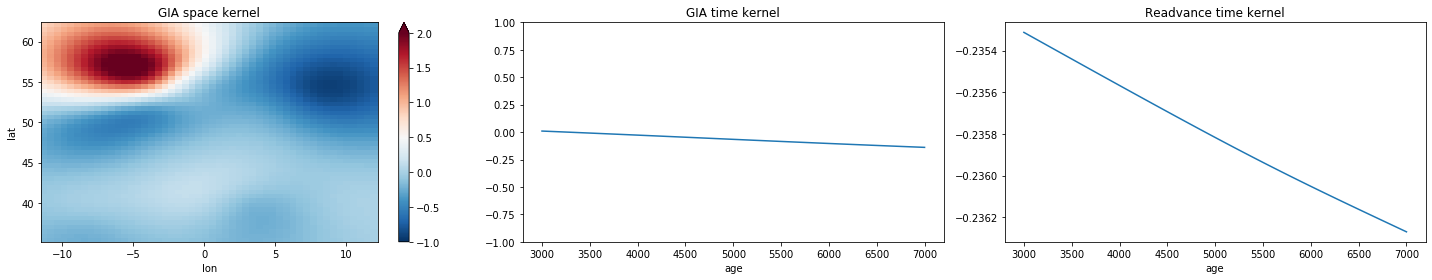

In [344]:
fig, ax = plt.subplots(1,3, figsize=(20,4))
ax = ax.ravel()
da_A1[0,:,:].plot(ax=ax[0], vmin=-1, vmax=2, cmap='RdBu_r')
ax[0].set_title('GIA space kernel')

da_A2[:,0,0].plot(ax=ax[1])
ax[1].set_ylim(-1, 1)
ax[1].set_title('GIA time kernel')

# da_A3[0,:,:].plot(ax=ax[2], vmin=-1, vmax=0)
# ax[2].set_title('Readvance space kernel')

da_A4[:,0,0].plot(ax=ax[2])
ax[2].set_title('Readvance time kernel');
plt.tight_layout()

# Compare to Input residuals

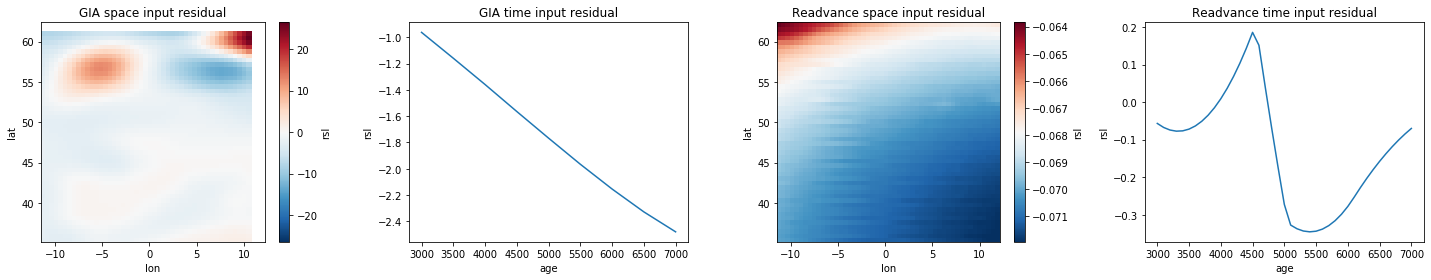

In [345]:
da_giaresidinterp = interp_likegpr(ds_diff - ds_area)
da_readvresidinterp = interp_likegpr(ds_readv - ds_readvprior)

fig, ax = plt.subplots(1,4, figsize=(20,4))
ax = ax.ravel()
da_giaresidinterp[:,:,0].plot(ax=ax[0], cmap='RdBu_r')
ax[0].set_title('GIA space input residual')

da_giaresidinterp[0,0,:].plot(ax=ax[1])
ax[1].set_title('GIA time input residual')

da_readvresidinterp[:,:,0].plot(ax=ax[2], cmap='RdBu_r')
ax[2].set_title('Readvance space input residual')

da_readvresidinterp[0,0,:].plot(ax=ax[3])
ax[3].set_title('Readvance time input residual');

plt.tight_layout()

# Decomposed Kernels with priors

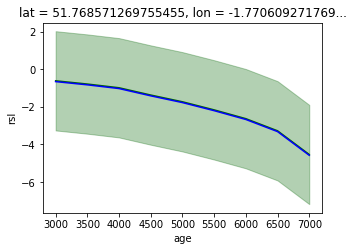

In [346]:
fig, ax = plt.subplots(1,1,figsize=(5,3.5))
loc1 = 30
loc2 = 20

top_giapost = (da_A2plusprior[:,loc1,loc2] + da_var2[:,loc1,loc2]*2).values
bottom_giapost = (da_A2plusprior[:,loc1,loc2] - da_var2[:,loc1,loc2]*2).values

# plt.plot(da_A2plusprior[:,10,10])

da_A2plusprior[:,loc1,loc2].plot(ax=ax, label='posterior RSL', color=postcolor)
da_giapriorinterp[loc1,loc2,:].plot(ax=ax, label='"true" RSL', color='blue')
ax.fill_between(da_readvpriorinterp.age, top_giapost, bottom_giapost, alpha=0.3, color=postcolor, label="$2 \sigma$")

In [347]:
da_A1plusprior = da_A1 + da_giapriorinterp
da_A2plusprior = da_A2 + da_giapriorinterp
# da_A3plusprior = da_A3 + da_readvpriorinterp
da_A4plusprior = da_A4 + da_readvpriorinterp

da_areamean = interp_likegpr(ds_area).mean(dim='age')
da_readvmean = ds_readv.rsl.mean(dim='age').transpose()
da_area_resid = da_A1plusprior[0,:,:] - da_areamean


top_post = (da_A4plusprior[:,10,10] + da_var4[:,10,10]*2).values
bottom_post = (da_A4plusprior[:,10,10] - da_var4[:,10,10]*2).values

top_readvprior = (da_readvpriorinterp[0,0,:] + da_readvpriorinterpstd[0,0,:]*2).values
bottom_readvprior = (da_readvpriorinterp[0,0,:] - da_readvpriorinterpstd[0,0,:]*2).values

top_giaprior = (da_giapriorinterp[0,0,:] + da_giapriorinterpstd[0,0,:]*2).values
bottom_giaprior = (da_giapriorinterp[0,0,:] - da_giapriorinterpstd[0,0,:]*2).values

/anaconda3/envs/gpflow5_0/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


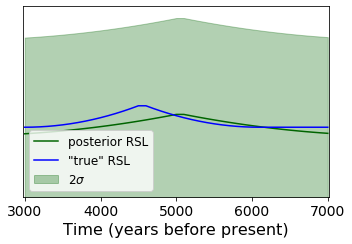

In [348]:
fig, ax = plt.subplots(1,1,figsize=(5,3.5))

postcolor = 'darkgreen'

da_A4plusprior.mean(dim=['lat', 'lon']).plot(ax=ax, label='posterior RSL', color=postcolor)
ds_readv.rsl.mean(dim=['lat', 'lon']).plot(ax=ax, label='"true" RSL', color='blue')
ax.fill_between(da_readvpriorinterp.age, top_post, bottom_post, alpha=0.3, color=postcolor, label="$2 \sigma$")

# ax.set_title('"True" vs. Posterior ', fontsize=18)
ax.set_xlim(tmin, tmax)
ax.set_ylabel('RSL (meters)', fontsize=16)
ax.set_xlabel('Time (years before present)', fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=14)
# ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)
ax.legend(loc='lower left', fontsize=12)
ax.set_ylim(-1.9, 3.3)
plt.tight_layout()

path = '/Users/rogercreel/Dropbox/Columbia_PhD/classes/QMDA/final_project/figs/'
fig.savefig(path + f'{run}_{ages[0]}to{ages[-1]}_{place}_giaplusreadv_decomposedtimeposterior_{maxscale_}_{postcolor}_fig', transparent=True)


/anaconda3/envs/gpflow5_0/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


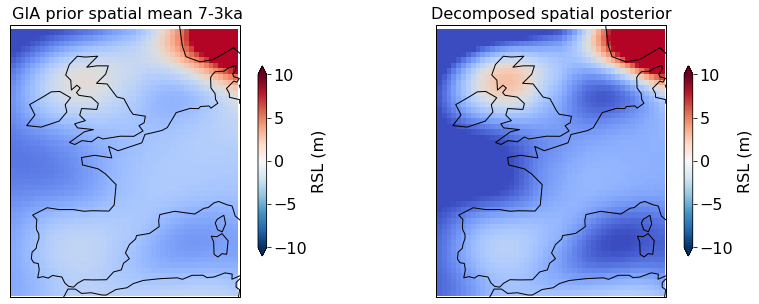

In [349]:
fontsize=16

da_areamean = interp_likegpr(ds_area).mean(dim='age')
da_readvmean = ds_readv.rsl.mean(dim='age').transpose()
cmap='coolwarm'

fig, ax = plt.subplots(1,2, figsize=(14,5),  subplot_kw=dict(projection=projection))
ax = ax.ravel()
da_areamean.plot(ax=ax[0], 
                 vmin=-10, 
                 vmax=15, 
                 cmap=cmap,
                 transform=proj,
                 add_colorbar=False,
                )
ax[0].set_title(' GIA prior spatial mean 7-3ka', fontsize=fontsize)
ax[0].coastlines(color='k')
ax[0].set_extent(extent_)
cb1 = fig.colorbar(da1,
                   ax=ax[0],
                   shrink=0.7, 
                   extend='both')
cb1.set_label('RSL (m)', fontsize=fontsize)
cb1.ax.tick_params(labelsize=fontsize)

da_A1plusprior[0,:,:].plot(ax=ax[1],
                           vmin=-10, 
                           vmax=15, 
                           cmap=cmap,
                           transform=proj,
                           add_colorbar=False,
                          )
ax[1].set_title('Decomposed spatial posterior', fontsize=fontsize)
ax[1].coastlines(color='k')
ax[1].set_extent(extent_)
cb1 = fig.colorbar(da1, 
                   ax=ax[1],
                   shrink=0.7, 
                   extend='both')
cb1.set_label('RSL (m)', fontsize=fontsize)
cb1.ax.tick_params(labelsize=fontsize)

path = '/Users/rogercreel/Dropbox/Columbia_PhD/classes/QMDA/final_project/figs/'
fig.savefig(path + f'{run}_{ages[0]}to{ages[-1]}_{place}_giaprior_decomposedspatialposterior_fig', transparent=True)

